# MATHEMATICAL MODELS AND NUMERICAL METHODS FOR BIG DATA 
**Zangrando Emanuele**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from keras.datasets import mnist
import networkx as ntx
import sklearn
from sklearn.neighbors import kneighbors_graph
import scipy
from scipy import sparse
import random


random.seed(42)

## ARTIFICIAL DATASET 

The Knn graph is naturally directed since the relation "to be one of the k nearest neighborhood" is not symmetric. So after creating the knn adjacency matrix, I symmetrized it and then renormalized the entries to be in $\{0,1\}$.

In [3]:
#Definition of the adjacency matrix given the data
def adjacency_knn_matrix(X,kn,metric_type="binary",norm=2):    #check this function, it has to return at least degree one for each node for kn=1
    '''INPUT:
     X = matrix with datapoints as rows
     kn = number of k-nearest-neighbors
     metric = specify wether we want a binary matrix or we want to use the distance in the weights via exp(-|xi-xj|**2)
     OUTPUT:
     A = binary adjacency matrix of the graph obtained from datapoint using knn or a weighted version if metric!="binary"
     '''
    def Lp_norm(vec,p):
      return (np.sum(abs(vec)**p))**(1/p)
    n = len(X)
    data_dim = len(X[0])
    A = np.zeros((n,n))
    for i in range(n):
      for j in range(i+1,n):
        A[i,j] = np.exp(-Lp_norm(X[i]-X[j],norm)**2/4)         #construction of the weighted adjacency matrix 
        A[j,i] = A[i,j]

    for i in range(n):                                         #deleting entries of the non k-nearest neighbors
      not_max_index = np.argpartition(A[i,], n-kn)[:n-kn]
      A[i,list(not_max_index)] = 0.                            #for every node we keep non null only the entries of its knn
    if metric_type == "binary":
      return np.sign(0.5*(np.sign(A) +np.sign(A).T))           #symmetrization and change in the entries
    return A

To create the disks I just parametrized every circle with the angle $\theta \rightarrow (rcos(\theta),rsin(\theta))$ and for every one of those I extracted the right number of uniformly distributed angles between $[0,2\pi)$. For every one of these sampled points I added a normally distributed noise along the circle's normal direction in that point.
The noise_level parameter is controlling the variance of the normal distribution.

In [4]:
def create_disc_data(classes_size,radii,noise_level):
  '''
  INPUT: 
  classes_size = list containing the sizes of each cluster of data
  radii = list containing the radii of the circles on which data are sampled
  noise_level = parameter controlling the noise orthogonal to the circles
  OUTPUT:
  X = matrix whose rows are the datapoints
  '''
  def normal(point):
    '''
    INPUT:
    point: non-zero point in R^2
    OUTPUT:
    normal vector to the circe at that point
    '''
    angle = np.arctan(point[0]/point[1])
    return np.array([-np.sin(angle),np.cos(angle)])

  X=[]

  for c in range(len(radii)):
    for m in range(classes_size[c]):
      angle = 2*np.pi*np.random.uniform()
      point = radii[c]*np.array([np.cos(angle),np.sin(angle)])
      noise = noise_level*np.random.normal()*normal(point)
      point += noise
      X.append(point)
  return np.array(X)

noise_level:  0.2


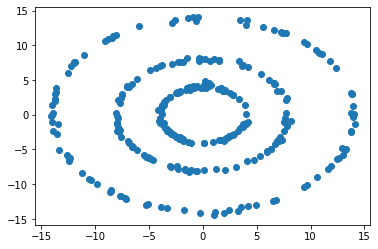

noise_level:  0.4


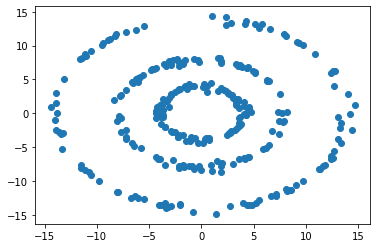

noise_level:  0.6


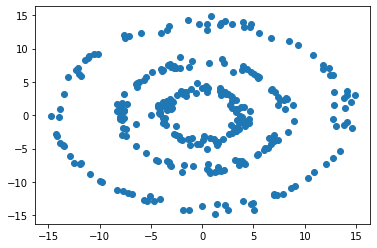

In [5]:
#TEST DATASET
classes_size,radii,noise_level = [100,100,100],[4,8,14],0.2

X = create_disc_data(classes_size,radii,noise_level)
print('noise_level: ',noise_level)
plt.scatter(X[:,0],X[:,1])
plt.show()

noise_level=0.4
X = create_disc_data(classes_size,radii,noise_level)
print('noise_level: ',noise_level)
plt.scatter(X[:,0],X[:,1])
plt.show()

noise_level=0.6
X = create_disc_data(classes_size,radii,noise_level)
print('noise_level: ',noise_level)
plt.scatter(X[:,0],X[:,1])
plt.show()

After that I constructed the function I needed in order to perform K-means algorithm.

In [6]:
# K-means function
def index_closest_centroids(point,centroids):
  '''
  INPUT:
  point :  numpy vector representing the position of the point
  centroids : list of centroids 
  OUTPUT:
  returns the index in the list "centroids" corresponding to the nearest from point
  '''
  distances = []
  for c in centroids:
    distances.append(np.linalg.norm(point-c))
  distances = np.array(distances)
  return np.argmin(distances)

def compute_centroids(X,classes):
  '''
  INPUT:
  X = matrix with datapoint as rows
  classes = list of lists containing classes of indeces for clusters in X
  OUTPUT:
  centroids = matrix with centroids as rows
  '''
  centroids = np.zeros((len(classes),len(X[0])))
  for i in range(len(classes)):
    if classes[i] != []:
      centroids[i] = np.mean(X[classes[i],:],axis=0)
    else:
      centroids[i] = X[np.random.choice(range(len(X)))]
  return centroids
  
def assign_classes(X,centroids):
  '''
  INPUT:
  X = matrix with datapoint as rows
  centroids = matrix with centroids as rows
  OUTPUT:
  classes = list of lists containing classes of indeces for clusters in X assigned based on the nearest centroid
  '''
  classes = [[] for i in range(len(centroids))]
  for i in range(len(X)):
    classes[index_closest_centroids(X[i],centroids)].append(i)
  return classes

def k_means_loss(X,classes,centroids):
  '''
  INPUT:
  X = matrix with datapoint as rows
  classes = list of lists containing classes of indeces for clusters in X assigned based on the nearest centroid
  centroids = matrix with centroids as rows
  OUTPUT:
  loss = loss function for k-means
  '''
  distances = []
  for i in range(len(classes)):
    for ind in classes[i]:
      distances.append(np.linalg.norm(X[ind]-centroids[i])**2)
  loss = np.sum(np.array(distances))
  return loss

def k_means_single_iteration(X,starting_centroids):
  '''
    Single iteration of k_means
    INPUT:
    X = matrix with datapoints as rows
    starting_centroids = matrix whose rows are the starting centroids
    OUTPUT:
    classes = list of indexes of elements in each class
    centroids = final centroids

  '''
  classes = assign_classes(X,starting_centroids)
  centroids = compute_centroids(X,classes)
  return classes,centroids


def k_means(X,starting_centroids,tol=1e-8,max_iterations=10000):
  '''
    INPUT:
    X = matrix with datapoints as rows
    starting_centroids = matrix whose rows are the starting centroids
    n_iteration = number of iterations
    OUTPUT:
    classes = list of indexes of elements in each class
    centroids = final centroids
    losses = history of the loss function
  '''
  losses = [k_means_loss(X,assign_classes(X,starting_centroids),starting_centroids)]
  centroids_distance = [] #[c_dist(starting_centroids)]
  centroids = deepcopy(starting_centroids)
  error = tol+1000
  t=1
  while t<=max_iterations and error>tol  :
    old_centroids = deepcopy(centroids)
    classes,centroids = k_means_single_iteration(X,centroids)
    error = np.linalg.norm(centroids-old_centroids,ord=1)
    losses.append(k_means_loss(X,classes,centroids))
    centroids_distance.append(error)#c_dist(centroids))
    t+=1
  return classes,centroids,losses,centroids_distance



def multiple_k_means(X,K,n_sims=5,tol=1e-8,max_iterations=10000):

  '''
    INPUT:
    X = matrix with datapoints as rows
    K = number of clusters
    n_sims = number of times to restart k_means with random initial configuration
    n_iteration = number of iterations
    OUTPUT:
    classes = list of best configuration
    centroids = final best centroids
    losses = history of the best loss
  '''
  n = X.shape[0]

  starting_centroids = X[np.random.choice(range(n),size=K),:]

  best_classes,best_centroids,best_losses,best_centroids_distance = k_means(X,starting_centroids,tol,max_iterations)

  for i in range(n_sims-1):

    starting_centroids = X[np.random.choice(range(n),size=K),:]

    classes,centroids,losses,centroids_distance = k_means(X,starting_centroids,tol,max_iterations)

    if losses[len(losses)-1]<best_losses[len(best_losses)-1]:

      best_classes,best_centroids,best_losses,best_centroids_distance  = classes,centroids,losses,centroids_distance

  return best_classes,best_centroids,best_losses,best_centroids_distance


### testing k-means on circles dataset with Euclidean coordinates

Here I put the code for the validation metrics and the functions that draws the actual graph.

In [7]:
#functions for the accuracy measures and for drawing the graph using the real points' coordinates

def validation_metrics(classif,true_classes):
  '''
  INPUT:
  classes = classes predicted by the k-means
  true_classes = true labels of the points
  OUTPUT:
  accuracy = percentage of correctly classified
  precision = mean statistical precision over the classes
  recall = Per each class compute the ratio (number of correctly assigned points to that class) / 
                                            (total number of points that really are in the class). 
                                            Then, take the mean over the recall of the classes
  '''
  K = len(true_classes)
  classes = sorted(classif)


  correctly_class = [len([el for el in classes[i] if el in true_classes[i]]) for i in range(len(classes))]   
  accuracy = np.sum(correctly_class)/len([x for el in true_classes for x in el ])
  precision = np.sum([correctly_class[i]/len(classes[i]) for i in range(len(classes))])/len(true_classes)   
  recall = np.sum([correctly_class[i]/len(true_classes[i]) for i in range(len(classes))])/len(true_classes)
  return accuracy,precision,recall



#Function for the graph drawing using datapoints coordinates
def draw_graph(A,X,coordinates="real"):
  '''
  INPUT:
  A = adjacency matrix of the graph (possibly weighted)
  X = matrix whose rows contains the coordinates of the points
  coordinates = flag variables, if 'real' then to draw the graph we use the coordinates of the points
  OUTPUT:
  This functions returns None, it just shows the plot of the graph
  '''
  G = ntx.convert_matrix.from_numpy_matrix(A)
  if coordinates!='real':
    ntx.drawing.nx_pylab.draw_networkx(G,node_size=50,with_labels=False,linewidths=0.5)
    return None
  node = list(G.nodes)
  coordinate_dict=dict()
  for el in node:
    coordinate_dict[el] = X[el]
  ntx.drawing.nx_pylab.draw_networkx(G,coordinate_dict,node_size=50,with_labels=False,linewidths=0.5)

In the following piece of code I put the functions needed to implement the power method for finding the $m$ smallest eigenvalues/vectors of the normalized Laplacian.

In [26]:
#Functions for the construction of the normalized Laplacian and for the Power method

def normalized_laplacian(A):
  '''
  INPUT:
  A = adjacency matrix
  OUTPUT:
  returns the normalized Laplacian matrix associated to A
  '''
  D = np.diag(np.sum(A,axis=1))
  L = D-A
  sqrtD = np.diag(np.sum(A,axis=1)**(-0.5))
  return sqrtD@L@sqrtD

def orthonormalize(basis,vec):
  '''
  INPUT:
  basis = matrix whose rows are a vector basis
  vec = vector we want to orthonormalize w.r.t basis
  OUTPUT:
  v = orthonormalized vec
  '''
  U = basis
  v = deepcopy(vec)
  proj_v = (U.T@U)@v
  orth_v = v-proj_v
  return orth_v/np.linalg.norm(orth_v)



def power_method(Lf,n,tol=1e-8):
  '''
  INPUT:
  Lf : python function associated to a matrix-vector product
  n : size of input vectors for Lf
  tol : tolerance set for the stopping criterion
  OUTPUT:
  It applies the power method on the linear operator Lf(x) and returns:
  x : eigenvector associated to the largest eigenvalue
  lambda1 : largest eigenvalue of Lf

  The stopping criterion is on the difference between successive approximations of the eigenvalue
  '''
  x=np.random.normal(size=n)
  x=x/np.linalg.norm(x)
  lambda0=x.T@Lf(x)
  lambda1=( Lf(x)/np.linalg.norm(Lf(x)) ).T@  Lf( Lf(x)/np.linalg.norm(Lf(x)) )
  x=Lf(x)/np.linalg.norm(Lf(x))
  error=abs(lambda1-lambda0)
  while error>tol:
    x = Lf(x)
    x = x/np.linalg.norm(x)
    lambda0,lambda1 = lambda1, x.T@Lf(x)
    error = abs(lambda1-lambda0)
  return x,lambda1 


def Lf(L):        
  '''
  INPUT:
  L = a matrix 
  OUTPUT:
  returns the python function associated to the matrix L
  '''
  def f(x):
    return L@x
  return f 



def deflation(Lf,eigenvector,eigenvalue):
  '''
  INPUT:
  Lf = python function associated with the matrix vector product
  eigenvectors = matrix whose rows contain some eigenvectors of Lf
  eigenvalues = corresponding vector of eigenvalues
  OUTPUT:
  f = python function associated to the deflation version of Lf 
  '''
  def f(x):
    result = Lf(x)-eigenvalue*(Lf(x).T@eigenvector)*eigenvector
    return result

  return f




def first_m_eigvectors_power_method(L, m,tol=1e-8,from_smallest=True):                
  '''
  This function is thought for constructed for the Laplacian, the initial deflation is made for it.
  Generic function that computes the first m eigenvectors of L using the power method
  INPUT:
  L = matrix used in power methods
  m = number of eigenvectors we want to compute (the m associated with the m biggest eigenvalues of L)
  OUTPUT:
  U = matrix whose columns are eigenvectors of L
  eigs = vector containing the m smallest eigenvalues of L
  '''
  n = len(L)
  eigs = np.zeros(m)
  U = np.zeros((m,n))
  mat = L
  if from_smallest == True:
    mat = 2*np.identity(n)-L
  Lmap = Lf(mat)
  for i in range(m):
    v,eigs[i] = power_method(Lmap,n,tol)
    v = orthonormalize(U,v)
    U[i] = v
    Lmap = Lf(mat-U.T@(np.diag(eigs)@U))
  if from_smallest == True: 
    return U.T,2-eigs[0:m]
  else:
    return U.T, eigs[0:m]

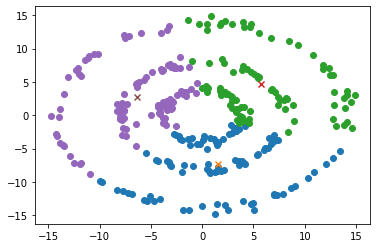

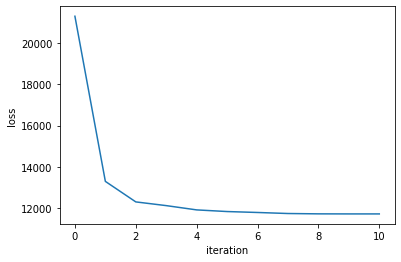

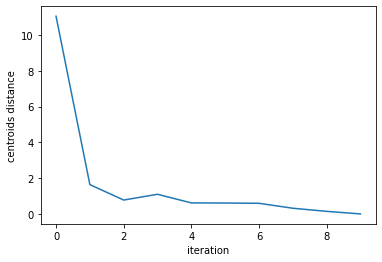

accuracy, precision, recall:  (0.3466666666666667, 0.3463250866384289, 0.3466666666666667)


In [9]:
#raw K-means test on the noisy circles dataset
tol = 1e-16
max_it = 100
K = 3
n_sims = 10

classes,centroids,losses,centroids_distance = multiple_k_means(X,K,n_sims,tol,max_it)
for i in range(K):
  plt.scatter(X[classes[i],0],X[classes[i],1])
  plt.scatter(centroids[i,0],centroids[i,1],marker="x")
plt.show()
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()
plt.plot(centroids_distance)
plt.xlabel("iteration")
plt.ylabel("centroids distance")
plt.show()

true_classes = [list(range(sum(classes_size[0:i-1]),sum(classes_size[:i]))) for i in range(1,len(classes_size)+1)]
print('accuracy, precision, recall: ',validation_metrics(classes,true_classes))

As we saw in class this kind of configuration isn't working well with the "raw" k-means.

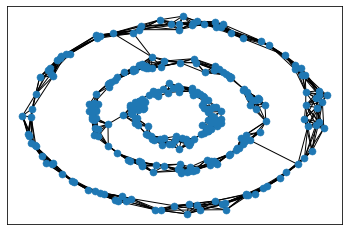

In [11]:
#plot of the knn graph 
knn = 8
A = adjacency_knn_matrix(X,knn)
draw_graph(A,X)                      #drawing the graph using points' coordinates

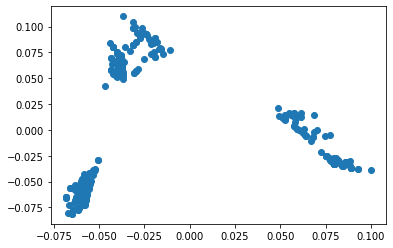

In [12]:
#testing the power method function on the normalized Laplacian and plot dataset points in Laplacian coordinates

K = 3
m = K
tol = 1e-8
L = normalized_laplacian(A)

U,eigs = first_m_eigvectors_power_method(L,m,tol)
new_X = U[:,range(1,m)]                                 #dataset points in Laplacian coordinates
plt.scatter(new_X[:,0],new_X[:,1])
plt.show()

We saw in class that Laplacian coordinate embedding $\mathcal{L}(x_{i})=e_{i}^{T}U_{K}$ is constructed in such a way that it minimizes the expected distance between connected points: $$\underset{(i,j)\sim Unif\{1,..,n\}^2}{\mathbb{E}}\Bigl[ A_{ij} ||\mathcal{L}(x_{i})-\mathcal{L}(x_{j})||_{2}^{2}  \Bigr]$$
This is in fact graphically confirmed in the last plot, we can clearly see points clustered in the "usual" sense.

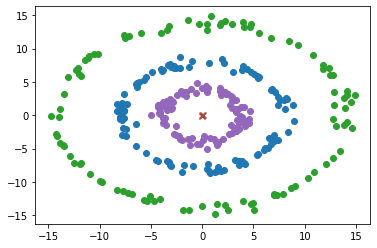

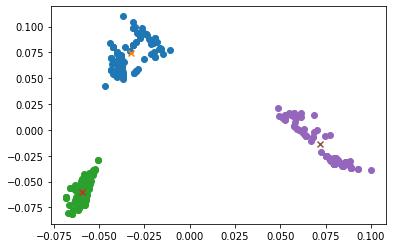

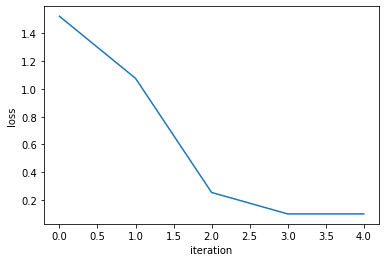

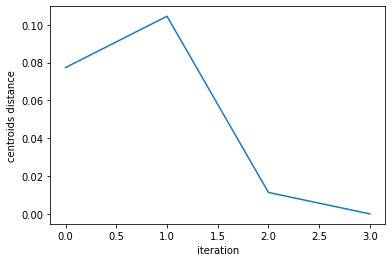

accuracy, precision, recall:  (1.0, 1.0, 1.0)


In [13]:
#K-means test using Laplacian coordinates
tol = 1e-16
max_it = 100
K = 3
n_sims = 10

classes,centroids,losses,centroids_distance = multiple_k_means(new_X,K,n_sims,tol,max_it)
for i in range(K):
  plt.scatter(X[classes[i],0],X[classes[i],1])
  plt.scatter(centroids[i,0],centroids[i,1],marker="x")
plt.show()
for i in range(K):
  plt.scatter(new_X[classes[i],0],new_X[classes[i],1])
  plt.scatter(centroids[i,0],centroids[i,1],marker="x")
plt.show()
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()
plt.plot(centroids_distance)
plt.xlabel("iteration")
plt.ylabel("centroids distance")
plt.show()

true_classes = [list(range(sum(classes_size[0:i-1]),sum(classes_size[:i]))) for i in range(1,len(classes_size)+1)]
print('accuracy, precision, recall: ',validation_metrics(classes,true_classes))



In the plots above we can notice that the K-means converged to the right configuration in the new embedding space. At the same time I plotted the corresponding classification in the original space to see that it's the correct one.

## Task 7. (Optional) 
Change the paramters generating the data
On top of computing the validation metrics for this particular setting, it would be nice to have a validation across different rages of the parameters. For example, you could run again the method for different values of knn, different number of points in the classes, different radii for the circles and observe that things do not work all the time (or they work very differently all the time)

In [ ]:
#TEST FUNCTION

def test(par):
  K = 3
  m = K
  tol = 1e-8           #tolerace for power method
  n_total_points,radii_difference,noise_level,knn = int(par[0]),int(par[1]),int(par[2]),int(par[3])

  classes_size,radii,noise_level = [int(n_total_points/K) for i in range(K)],[4,4+radii_difference,4+2*radii_difference],noise_level
  X = create_disc_data(classes_size,radii,noise_level)
  A = adjacency_knn_matrix(X,knn)
  L = normalized_laplacian(A)
  U , _ = first_m_eigvectors_power_method(L,m,tol)
  new_X = U[:,range(1,m)]
  starting_centroids = new_X[np.random.choice(range(new_X.shape[0]-1),size=K),:]
  classes,centroids,losses,centroids_distance = k_means(new_X,starting_centroids,1e-10,100)
  true_classes = [list(range(sum(classes_size[0:i-1]),sum(classes_size[:i]))) for i in range(1,len(classes_size)+1)]
  return validation_metrics(classes,true_classes)

measures = []
n_tests = 8
n_total_points = [100*i for i in range(1,n_tests)]                    
radii_differences = [3*i for i in range(1,n_tests)]
noise_levels = [0.1*i for i in range(1,n_tests)]
knn_s = [8+2*i for i in range(1,n_tests)]

for i in range(n_tests-1):
  measures.append( test( (n_total_points[i],radii_differences[i],noise_levels[i],knn_s[i] )  )  )
  print('test # ',i)
  print('total_points: ',n_total_points[i])
  print('radii_difference: ',radii_differences[i])
  print('noise_levels: ',noise_levels[i])
  print('nearest neigh: ',knn_s[i])
  print('RESULTS:')
  print('accuracy,precision,recall: ',measures[i])
  print('-------------------------------------------------------------------------------------------------------------')
  print('\n')




test #  0
total_points:  100
radii_difference:  3
noise_levels:  0.1
nearest neigh:  10
RESULTS:
accuracy,precision,recall:  (0.32323232323232326, 0.3225830872889696, 0.32323232323232326)
-------------------------------------------------------------------------------------------------------------


test #  1
total_points:  200
radii_difference:  6
noise_levels:  0.2
nearest neigh:  12
RESULTS:
accuracy,precision,recall:  (0.5757575757575758, 0.5560320182961692, 0.5757575757575758)
-------------------------------------------------------------------------------------------------------------


test #  2
total_points:  300
radii_difference:  9
noise_levels:  0.30000000000000004
nearest neigh:  14
RESULTS:
accuracy,precision,recall:  (0.65, 0.64999833316665, 0.65)
-------------------------------------------------------------------------------------------------------------


test #  3
total_points:  400
radii_difference:  12
noise_levels:  0.4
nearest neigh:  16
RESULTS:
accuracy,precision,r

From this kind of tests one can obtain some insights on how the K-mean works with different parameters. To try to understand how the accuracy measures behaves as a function of all the parameters jointy, one could perhaps try to fit a probabilistic model on the simulated results. In this way one can at least understand qualitatively how the change in one parameter influence the accuracy and how one can modify them jointly to keep it high. The simplest (but probably the least efficient) is to use a logistic regression model.

For simplicity I tried just with the accuracy as a measure. Rasterize the space of the parameters is expensive, I just fulfilled it with a random sample of parameters. 

(I did not finish this code, but I left it hidden here in the Graveyard).


## Task 8.
 Design a function that computes the m smallest eigenvalues of the normalized Laplacian using Krylov approach
Use free book of Y Saad Numerical methods for large eigenvalue problems and our lecture notes to define the function that computes the first m eigenvectors of L using Krylov

Note that internally you will need to compute the eigenvalues/vectors of the matrices  $H_m$ . These matrices are small and full (not sparse!). You can use built-in full matrix eigensolvers for this:

eig in Matlab
eigvectors in Julia
numpy.linalg.eig in python

In [14]:
# Arnoldi method
def arnoldi_iteration(M, b,k,tol=1e-6,max_restarting=100):

  flag = False

  y = b

  m = 5*k

  times_restarting = 0

  while flag ==False and times_restarting<=max_restarting:
    
    n = M.shape[0]
    u_i = y/np.linalg.norm(y) 
    U = np.zeros((n,m+1))
    h = np.zeros((m+1,m))
    U[:,0] = u_i
    for i in range(m):
      W = M@u_i
      h_i = U.T@W
      v_i = W - U@h_i
      h[:,i] = h_i
      h[i+1,i] = np.linalg.norm(v_i)
      flag = bool(h[i+1,i]<tol)
      if flag==True and i>=k:
        H_i = h[np.ix_(range(i+1),range(i+1))]
        U_i = U[:,0:i+1]
        eigenvalues,eigenvectors = np.linalg.eig(H_i)
        return eigenvalues, U_i@eigenvectors
        #return H_i,U_i
        
      u_i = v_i/h[i+1,i]
      U[:,i+1]= u_i
    
    H_new = h[0:m]
    U_new = U[:,0:m]
    _,restart_eigenv = np.linalg.eig(H_new)
    y = np.sum(restart_eigenv,axis=1)
    y = U_new@y
    times_restarting+=1


  print('no convergence')
  return h,U

In [16]:
eigs,eigenv = arnoldi_iteration(L,np.random.normal(size = len(L)),k=3,tol=0.1)

# Optional (compare eigensolvers)
Compare built-in eigensolvers with power and Arnoldi iteration.

Here I compared the performance of the eigensolver I constructed using power method+deflation with the built in eigensolver. 
To be unbiased I decided to randomly generate the test matrices in different ways: normally distributed or uniformly distributed in some hyperinterval.
I also included the possibility for the matrix to be sparse by multiplying it by a mask matrix with Bernoulli distributed entries (p is the Bernoulli parameter in the code). As a measure of error I decided to use  the $L^{\infty}$ (not the operatorial) norm both for the eigenvectors and for the eigenvalues. 

If $\tilde{U}\sim n\times m$ is the matrix whose columns are the approximation of the first $m$ eigenvectors of $M$ and $U$ is the one returned by built-in eigensolvers then I calculated the relative error as
$$
\epsilon_{eigenv} = ||\tilde{U}-U||_{\infty}=max_{i,j}|\tilde{U}_{ij}-U_{ij}|
$$

Similarly if $\tilde{\lambda}$ is the vector containing the approximation of the $m$ biggest eigenvalues of M and $\lambda$ is the true one I used

$$
\epsilon_{eigs} = ||\tilde{\lambda}-\lambda||_{\infty}=max_{i}|\tilde{\lambda}_{i}-\lambda_{i}|
$$

The idea is to randomly extract a bunch of random matrices and look and the distribution of errors, I did that for different distributions and I plotted the empirical survival function of the relative errors $t\rightarrow \hat{P}(\epsilon_{eigs}>t)$.

In [459]:
def test_eigensolver(n,m,matrix_type='dense',p=0.9,tol = 1e-12,distribution='u',sigma=1,measure='infty'):
  '''
  INPUT:
  n = size of the matrix we are testing eigensolvers on
  m = number of eigenvalues/vectors of the spectra to confront
  tol = tolerance for the eigensolvers
  matrix_type = flag for the type of matrix to randomly generate, full or sparse
  OUTPUT:

  '''
  if distribution=='u':
    M = sigma*np.random.random(size=(n,n))
  elif distribution=='g':
    M = sigma*np.random.normal(size=(n,n))
  else:
    M = sigma*np.random.choice([0,1],size=(n,n),p=[p,1-p])
  if matrix_type!='dense':
    mask_matrix = np.random.choice([0,1],size=(n,n),p=[p,1-p])
    M = M*mask_matrix
  M = 0.5*(M+M.T)                           # so that the spectra is real

  print('matrix condition number: ',np.linalg.cond(M,2))

  U,eig = first_m_eigvectors_power_method(M,m,tol,False)

  eig1,U1 = np.linalg.eigh(M) 

  L = [(abs(eig1[i]),i)  for i in range(len(eig1)) ]
  L.sort(reverse = True)
  _,permutation = zip(*L)
  permutation = list(permutation)

  eig1,U1 = eig1[permutation],U1[:,permutation]
  eig1,U1 = eig1[range(m)],U1[:,range(m)]


  print('our_error: ',np.linalg.norm(M@U-U@np.diag(eig)))
  print('python_error: ',np.linalg.norm(M@U1-U1@np.diag(eig1)))


  if measure=='infty':

    eigenvector_err = np.max(abs(U-U1))
    eigenvalues_err = np.max(abs(eig-eig1))

  else:

    eigenvector_err = np.linalg.norm(U-U1)             #classical L^2 error measures
    eigenvalues_err = np.linalg.norm(abs(eig-eig1))


  print('eig_err: ',eigenvalues_err)
  print('eigenv_err: ',eigenvector_err)
  print('=================================================================')

  

  return eigenvalues_err,eigenvector_err

In [462]:
#Dense Uniformly distributed matrices test

def test_plot(n,m,n_sims,distribution='u',matrix_type='dense',p=0.9,tol = 1e-12,sigma=1,measure='infty'):


  errors = []

  for i in range(n_sims):

    print('test '+':',i)

    errors.append(test_eigensolver(n,m,matrix_type,p,tol,distribution,sigma,measure))

  errors = np.array(errors)
  

  plt.hist(errors[:,0],cumulative=-1,density=True,bins=int(n_sims/2))
  plt.xlabel('eps')
  plt.xscale('log')
  plt.ylabel('P(max eigenvalue error > eps)')
  plt.show()

  plt.hist(errors[:,1],cumulative=-1,density=True,bins=int(n_sims/2),)
  plt.xlabel('eps')
  plt.ylabel('P(max eigenvector error > eps)')
  plt.show()

  return errors

test : 0
matrix condition number:  1706.8586350565847
our_error:  2.3146851213466278e-05
python_error:  6.442800864929502e-14
eig_err:  6.812107768543002e-11
eigenv_err:  2.8284271247446586
test : 1
matrix condition number:  1978.808383965903
our_error:  2.4052168241593027e-05
python_error:  3.4443538825633546e-14
eig_err:  7.512923650159586e-11
eigenv_err:  3.1238996496125583e-06
test : 2
matrix condition number:  1180.3040839089629
our_error:  3.118055225884827e-05
python_error:  6.258193682075101e-14
eig_err:  1.2455237348587187e-10
eigenv_err:  1.9999999999960096
test : 3
matrix condition number:  992.7385306949367
our_error:  1.1805954777272343e-05
python_error:  7.802900523683155e-14
eig_err:  1.799685549616291e-11
eigenv_err:  1.5245514625444508e-06
test : 4
matrix condition number:  873.5924376890704
our_error:  8.003599285447108e-06
python_error:  4.4586912642485956e-14
eig_err:  7.927995202760292e-12
eigenv_err:  2.8284271247460158
test : 5
matrix condition number:  4709.4138

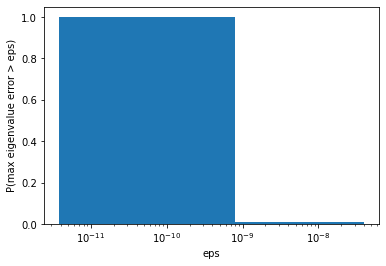

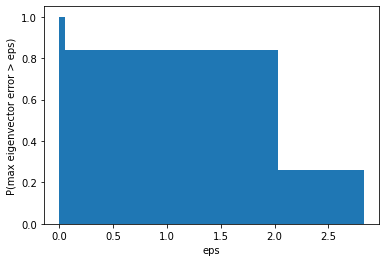

In [465]:
m = 2
n = 100
n_sims = 100

_ = test_plot(n,m,n_sims,measure=2)

I choose norm infinity because there is a big measure concentration around 0 and 2 and this is a little bit visually less useful. This is happening because our eigenvector is the opposite as the one returned by python and thus the difference is the doubled norm and since they are normalized it is two.

test : 0
matrix condition number:  5438.985091485772
our_error:  6.454736297604977e-08
python_error:  4.846883303472628e-14
eig_err:  2.842170943040401e-14
eigenv_err:  0.21638510514508516
test : 1
matrix condition number:  3187.399106106669
our_error:  4.951997197014612e-07
python_error:  5.805181984317255e-14
eig_err:  3.552713678800501e-14
eigenv_err:  3.2703211527707055e-09
test : 2
matrix condition number:  8602.206565553039
our_error:  8.537216857143155e-08
python_error:  4.8509505050807086e-14
eig_err:  1.4210854715202004e-14
eigenv_err:  0.22430615167532364
test : 3
matrix condition number:  3536.4277257609647
our_error:  9.624194912146905e-08
python_error:  5.1037424592545623e-14
eig_err:  2.842170943040401e-14
eigenv_err:  0.22544187025291562
test : 4
matrix condition number:  3430.2238417438716
our_error:  1.0388064214879678e-07
python_error:  4.839553726947542e-14
eig_err:  2.1316282072803006e-14
eigenv_err:  0.22095516717333652
test : 5
matrix condition number:  2213.58763

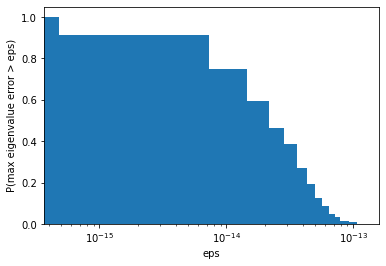

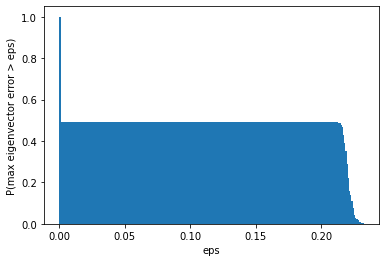

In [455]:
#first 2 eigenvector/value for 500 matrices uniformly distributed in [0,1]^n, DENSE
m = 1
n = 100
n_sims = 500

_ = test_plot(n,m,n_sims)

test : 0
matrix condition number:  4434.429398903722
our_error:  0.00010230816727488436
python_error:  4.6127644381776855e-14
eig_err:  5.580016448902825e-10
eigenv_err:  0.5963238495343813
test : 1
matrix condition number:  3641.9359328596775
our_error:  7.136829921887625e-05
python_error:  7.044236796479323e-14
eig_err:  1.5271206521560998e-10
eigenv_err:  0.5867012616787821
test : 2
matrix condition number:  6796.687648888163
our_error:  7.266724919027161e-05
python_error:  7.970999838740171e-14
eig_err:  1.279283345922977e-10
eigenv_err:  0.5667783708380526
test : 3
matrix condition number:  1731.5709260448962
our_error:  6.575831599165388e-05
python_error:  7.445185298977628e-14
eig_err:  9.544942614070351e-11
eigenv_err:  0.602971455293454
test : 4
matrix condition number:  4897.907299936034
our_error:  6.705023171116552e-05
python_error:  9.576573352098446e-14
eig_err:  1.188609211055791e-10
eigenv_err:  0.5254495693499763
test : 5
matrix condition number:  2566.393005528572
our

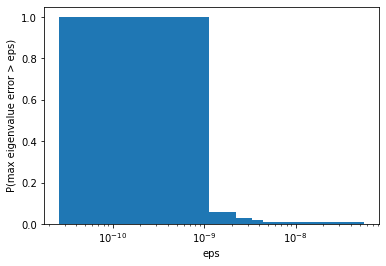

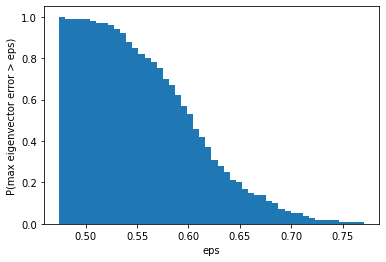

In [458]:
#first 10 eigenvector/value for 50 matrices uniformly distributed in [0,1]^n , DENSE
m = 10
n = 100
n_sims = 100

errors = test_plot(n,m,n_sims)

test : 0
matrix condition number:  1235.7375902425943
our_error:  8.557292044714048e-05
python_error:  1.8366948545420997e-14
eig_err:  1.7671553109721572e-10
eigenv_err:  0.6628145430632333
test : 1
matrix condition number:  329.14719968127844
our_error:  6.791696833866331e-05
python_error:  1.8374616873796004e-14
eig_err:  1.754556500088711e-10
eigenv_err:  0.6093750455825968
test : 2
matrix condition number:  537.331027860933
our_error:  5.02954016126438e-05
python_error:  1.9961564233623186e-14
eig_err:  3.630074019156382e-11
eigenv_err:  0.6559695209891349
test : 3
matrix condition number:  1251.1984331041112
our_error:  6.554524355415606e-05
python_error:  2.2018716587393698e-14
eig_err:  7.853451222672447e-11
eigenv_err:  0.7287148744908996
test : 4
matrix condition number:  1286.7002973394451
our_error:  5.532374458020742e-05
python_error:  2.0927903989675402e-14
eig_err:  5.5072391091925965e-11
eigenv_err:  0.6502693201664316
test : 5
matrix condition number:  584.987627662750

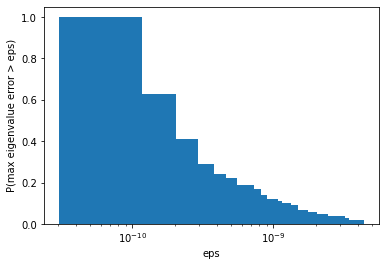

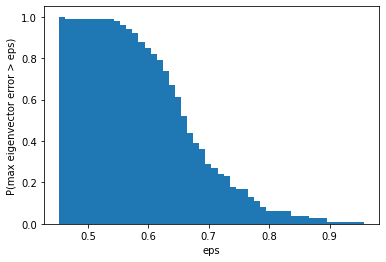

In [457]:
#first 10 eigenvector/value for 100 sparsified matrices uniformly distributed in [0,1]^n, SPARSE
m = 10
n = 100
n_sims = 100

errors = test_plot(n,m,n_sims,'sparse')

test : 0
matrix condition number:  507.9478448107602
our_error:  0.000112815411948817
python_error:  5.538620894001145e-14
eig_err:  6.085976167469198e-11
eigenv_err:  0.742176432412361
test : 1
matrix condition number:  107.04461393776288
our_error:  0.0002736394078006379
python_error:  5.294217540265795e-14
eig_err:  7.822169578730609e-10
eigenv_err:  0.6183185379197584
test : 2
matrix condition number:  360.0057283702506
our_error:  0.00011587949969780574
python_error:  5.620910371149468e-14
eig_err:  1.233608770689898e-10
eigenv_err:  0.6373864505567752
test : 3
matrix condition number:  216.95489440881943
our_error:  0.00015687344093127454
python_error:  5.146468352657439e-14
eig_err:  1.545892303056462e-10
eigenv_err:  0.7134641623623781
test : 4
matrix condition number:  173.140549611392
our_error:  0.00031634902141017886
python_error:  5.770066360109093e-14
eig_err:  1.8924168898593052e-09
eigenv_err:  0.662129840310123
test : 5
matrix condition number:  99.10108592385977
our_e

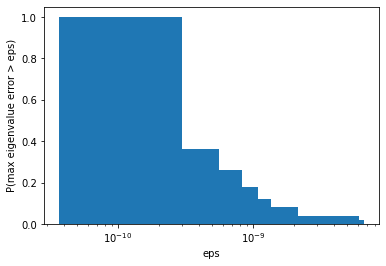

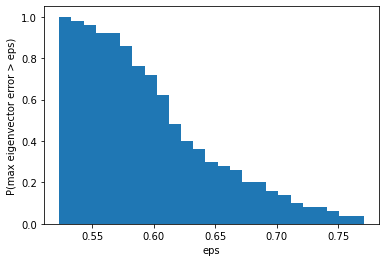

In [466]:
#first eigenvector/value for 50 normally distributed matrices ,DENSE
m = 10
n = 100
n_sims = 50

errors = test_plot(n,m,n_sims,'g','dense')

test : 0
matrix condition number:  94.4049020496189
our_error:  0.00040251972212605193
python_error:  5.984659163023907e-13
eig_err:  1.5498358152399305e-10
eigenv_err:  0.572721074055041
test : 1
matrix condition number:  302.8176520082899
our_error:  0.0003140876938216452
python_error:  5.728140311942511e-13
eig_err:  1.1397105481592007e-10
eigenv_err:  0.7329481999870746
test : 2
matrix condition number:  4973.459492211146
our_error:  0.0004267068969950791
python_error:  4.910409521163601e-13
eig_err:  1.779625335984747e-10
eigenv_err:  0.6051675912748762
test : 3
matrix condition number:  83.11699638163566
our_error:  0.0003653003259328134
python_error:  5.280291982950215e-13
eig_err:  1.3676526577910408e-10
eigenv_err:  0.6581701375402369
test : 4
matrix condition number:  168.52446864314393
our_error:  0.0005588210482666225
python_error:  5.388240778759241e-13
eig_err:  4.42710756942688e-10
eigenv_err:  0.7808671872893664
test : 5
matrix condition number:  110.92847670830125
our_

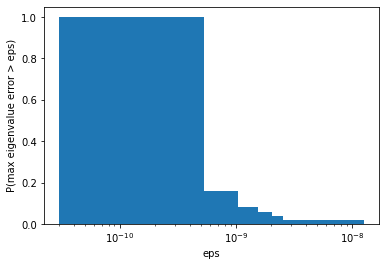

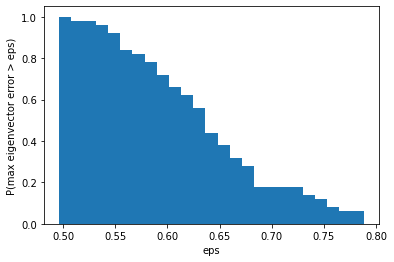

In [474]:
#first eigenvector/value for 50 normally distributed matrices with bigger variance
m = 10
n = 100
n_sims = 50

errors = test_plot(n,m,n_sims,'g','dense',sigma=10)

test : 0
matrix condition number:  191.90514622757573
our_error:  8.802967829835965e-05
python_error:  1.771441276456333e-14
eig_err:  2.1447466025392714e-10
eigenv_err:  0.8928334008313343
test : 1
matrix condition number:  488.7509189894798
our_error:  5.728042384110274e-05
python_error:  1.7819634384736115e-14
eig_err:  7.246736544175292e-11
eigenv_err:  0.9848819721053246
test : 2
matrix condition number:  393.00707719771214
our_error:  8.027288555433725e-05
python_error:  1.5334608017890854e-14
eig_err:  1.2831291584802784e-10
eigenv_err:  0.8544193779415982
test : 3
matrix condition number:  101.73818618642919
our_error:  9.160979048785284e-05
python_error:  1.7164379977249898e-14
eig_err:  4.957447785614022e-10
eigenv_err:  1.054328397905705
test : 4
matrix condition number:  354.883969489673
our_error:  9.515592408152307e-05
python_error:  1.625187419821548e-14
eig_err:  2.9791591416028496e-10
eigenv_err:  1.3998998352433571
test : 5
matrix condition number:  58.597268827624106

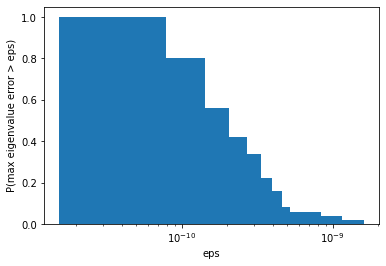

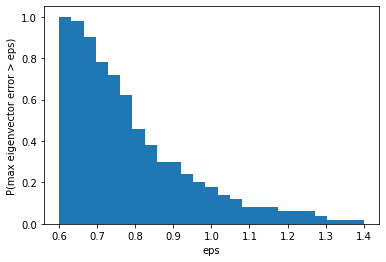

In [467]:
#first eigenvector/value for 50 normally distributed matrices , SPARSE
m = 10
n = 100
n_sims = 50

errors = test_plot(n,m,n_sims,'g','sparse')

test : 0
matrix condition number:  248.77367685484296
our_error:  8.703420425237292e-05
python_error:  2.0055324809651856e-14
eig_err:  2.881188621017827e-10
eigenv_err:  0.725990066919034
test : 1
matrix condition number:  222.06258893811008
our_error:  0.0006720227570065768
python_error:  2.1121627962529485e-14
eig_err:  2.868082793483495e-08
eigenv_err:  0.5941968671717826
test : 2
matrix condition number:  1125.352235119463
our_error:  9.57160269035664e-05
python_error:  1.6649652931169055e-14
eig_err:  4.667088937537756e-10
eigenv_err:  0.5573849882787811
test : 3
matrix condition number:  1406.215799381221
our_error:  5.977645887116474e-05
python_error:  1.984829851684186e-14
eig_err:  9.017364632768476e-11
eigenv_err:  0.5910690997655614
test : 4
matrix condition number:  853.6294422283374
our_error:  8.80436189191556e-05
python_error:  1.8850008115253836e-14
eig_err:  2.444040525517721e-10
eigenv_err:  0.6330893306546644
test : 5
matrix condition number:  1374.4933831421993
our

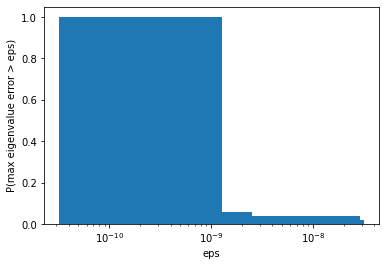

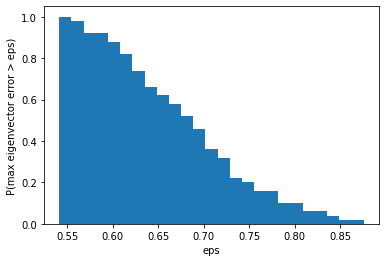

In [470]:
#first eigenvector/value for 50 bernoulli distributed matrices ,DENSE
m = 10
n = 100
n_sims = 50

errors = test_plot(n,m,n_sims,'bernoulli','dense')

test : 0
matrix condition number:  417.2373652208434
our_error:  6.0008897292126524e-05
python_error:  1.0595161777159287e-14
eig_err:  2.2356960727165642e-10
eigenv_err:  1.129585986988086
test : 1
matrix condition number:  273.5270104017565
our_error:  7.921036242421458e-05
python_error:  1.1889446156874338e-14
eig_err:  2.160294165776122e-10
eigenv_err:  0.854650484874764
test : 2
matrix condition number:  454.8000253649385
our_error:  5.028845254248247e-05
python_error:  1.3773020620297116e-14
eig_err:  8.721867672534245e-11
eigenv_err:  0.8769833703533101
test : 3
matrix condition number:  223.0998577107221
our_error:  5.2660810354784666e-05
python_error:  1.1547970372253384e-14
eig_err:  1.2449419273252715e-10
eigenv_err:  0.6440914520150165
test : 4
matrix condition number:  269.2666024323963
our_error:  4.515482005910755e-05
python_error:  1.1036076825203551e-14
eig_err:  6.7355010457959e-11
eigenv_err:  0.7279993790282376
test : 5
matrix condition number:  305.01096151364584
o

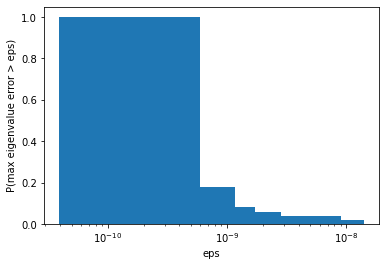

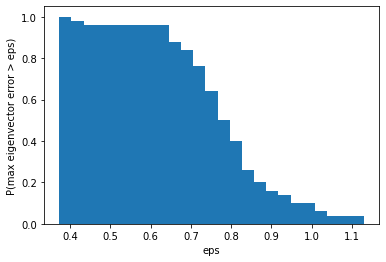

In [473]:
#first eigenvector/value for 50 Bernoulli distributed matrices ,SPARSE
m = 10
n = 100
n_sims = 50

errors = test_plot(n,m,n_sims,'bernoulli','sparse',0.8)

To conclude, I choose to test like this because this seemed to me a way to test a big variety of scenarios. The performance on the eigenvalues is good, but there are some entries of the eigenvectors that are badly approximated in every one of this scenarios. I noticed also that for almost every one of these distribution the performance on the eigenvectors is worse in the sparsified case, and even if the error on average is pretty much the same it seems visually less concentrated around zero.

I also printed the condition numbers of the generated matrices and they are pretty big in some case, and since the matrices are all simmetric this indicates a big variety in the magnitude of the eigenvalues. With this I would expect that the approximations will get worse with $m\approx n$ because of the deflation.

There must be something strange happening here, in the Euclidean coordinates the accuracy is not that bad and the distance between the centroids at two successive iterations seems to converge to zero pretty smoothly. Using Laplacian coordinates the accuracy is bad and it seems that the centroids are sort of jumping, I tried to think why this is happening but I got no good explaination.